# POI Data Analysis

## Import

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!% config InlineBackend.figure_format = 'retina'
from scipy import stats

/bin/bash: line 0: fg: no job control


## Load Data
Here we load the datasets, we first specify the datasets path and root folders then we load the datasets. To do the analysis, we first load the check-ins record dataset then to have some specific analysis on different users groups we create different group of users based on their activity and check-in frequancy: `low active`, `medium active`, `high active`, `very high active`.

### Root data path

In [2]:
# dataset specification
data_dir = "../datasets/"
group_dir = "../groups"
# you can change the dataset name when you want to run it on different dataset
dataset_name = "Yelp"

### Load check-ins data

In [3]:
# read user checkins
cols = ['user', 'poi', 'timestamp']
user_events_file = data_dir + dataset_name + "/" + dataset_name + "_checkins.txt"
df_events = pd.read_csv(user_events_file, sep='\t', names=cols)
print('No. of users: ' + str(len(df_events.user.unique())))
print('No. of items: ' + str(len(df_events.poi.unique())))
print('No. of user events: ' + str(len(df_events)))

No. of users: 7135
No. of items: 15575
No. of user events: 299327


In [4]:
df_events.head()

,user,poi,timestamp
0,0,0,1.185638e+09
1,0,8,1.185638e+09
2,0,2,1.185638e+09
3,0,3,1.185638e+09
4,0,4,1.185638e+09


In [5]:
# create user-item matrix
predict_col = 'poi'
df_events = df_events.groupby(['user', predict_col]).size().reset_index(name='count')
print('No. user-item interactions: ' + str(len(df_events)))

No. user-item interactions: 283291


### Load user groups data

In [6]:
if dataset_name == 'Gowalla':
  user_groups = ['19', '47', '94', 'more']
elif dataset_name == 'Yelp':
  user_groups = ['51', '128', '256', 'more']

In [7]:
low_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[0] + '.txt'
medium_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[1] + '.txt'
high_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[2] + '.txt'
veryhigh_user_file = group_dir + "/users/" + dataset_name + '/users_checkins_' + user_groups[3] + '.txt'

## Data Statistics

In [8]:
item_threshold = 1 # 1 means no filtering
df_events = df_events[df_events['count'] >= item_threshold]
print('No. filtered user check-ins: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user check-ins: 283291
No. filtered items: 15575


In [9]:
# get user distribution
user_dist = df_events['user'].value_counts()
num_users = len(user_dist)
print('Mean POIs per user: ' + str(user_dist.mean()))
print('Min POIs per user: ' + str(user_dist.min()))
print('Max POIs per user: ' + str(user_dist.max()))

Mean POIs per user: 39.70441485634198
Min POIs per user: 8
Max POIs per user: 951


In [10]:
# get item distribution
item_dist = df_events[predict_col].value_counts()
num_items = len(item_dist)
print('No. POIs: ' + str(num_items))

No. POIs: 15575


## Long-tail Anaylsis

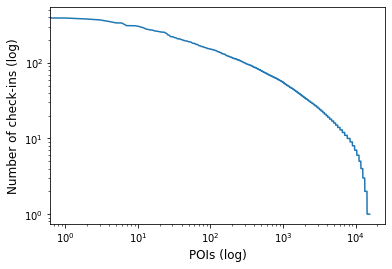

In [11]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('POIs (log)', fontsize='12')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.ylabel('Number of check-ins (log)', fontsize='12')
plt.xscale('log')
plt.yscale('log')
plt.savefig('results/' + dataset_name + '/' + 'long-tail-log.pdf', dpi=300, bbox_inches='tight')

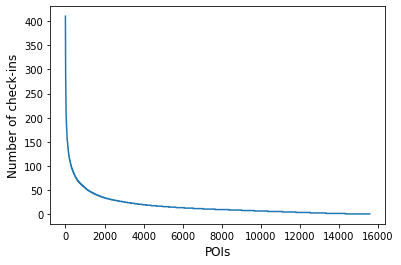

In [12]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('POIs', fontsize='12')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.ylabel('Number of check-ins', fontsize='12')
plt.savefig('results/' + dataset_name + '/' + 'long-tail-normal.pdf', dpi=300, bbox_inches='tight')

In [13]:
# get top items
top_fraction = 0.2
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 3115


In [14]:
# read users
low_users = pd.read_csv(low_user_file, sep=',', header=None)
medium_users = pd.read_csv(medium_user_file, sep=',', header=None)
high_users = pd.read_csv(high_user_file, sep=',', header=None)
veryhigh_users = pd.read_csv(veryhigh_user_file, sep=',', header=None)
no_users = len(low_users) + len(medium_users) + len(high_users) + len(veryhigh_users)
print(len(low_users), len(medium_users), len(high_users), len(veryhigh_users))
print('No. of users: ' + str(no_users))

3099 2444 954 638
No. of users: 7135


In [ ]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles

low_profile_size = 0
low_gap = 0

medium_profile_size = 0
medium_gap = 0

high_profile_size = 0
high_gap = 0
veryhigh_profile_size = 0
veryhigh_gap = 0

low_count = 0
med_count = 0
high_count = 0
veryhigh_count = 0

for u, df in df_events.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    elif u in high_users.index:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
    else:
        veryhigh_profile_size += no_user_items
        veryhigh_gap += user_pop_item_fraq
        veryhigh_count += 1

low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
veryhigh_profile_size /= len(veryhigh_users)

low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
veryhigh_gap /= len(veryhigh_users)

print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))
print('Very High count (for check): ' + str(veryhigh_count))

In [ ]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xlabel('User', fontsize='12')
plt.xticks(fontsize='10')
plt.ylabel('Ratio of popular POIs', fontsize='12')
plt.yticks(fontsize='10')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular POIs')
plt.legend(fontsize='10', loc = "lower right")
plt.savefig('results/' + dataset_name + '/' + 'user_poi_ratio.pdf', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='12')
plt.xticks(fontsize='10')
plt.ylabel('Number of popular POIs', fontsize='12')
plt.yticks(fontsize='10')
plt.savefig('results/' + dataset_name + '/' + 'corr_user_numebr.pdf', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='12')
plt.ylabel('Average popularity of POIs', fontsize='12')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.savefig('results/' + dataset_name + '/' + 'corr_user_avg.pdf', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_fraq)
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='12')
plt.ylabel('Percentage of popular POIs', fontsize='12')
plt.xticks(fontsize='10')
plt.yticks(fontsize='10')
plt.savefig('results/' + dataset_name + '/' + 'corr_user_prec.pdf', dpi=300, bbox_inches='tight')